In [31]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr
import datetime
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge


from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet 
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import missingno as msno

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

pd.set_option('display.max_columns', None)

%matplotlib inline

In [32]:
train_orig = pd.read_csv("../data/train.csv")
test_orig = pd.read_csv("../data/test.csv")

In [33]:
both = pd.concat((train_orig.drop(["SalePrice"], axis = 1), test_orig))

# Analysis of the Missing Values

In [4]:
train_orig.shape

(1460, 81)

In [5]:
test_orig.shape

(1459, 80)

In [6]:
both.shape

(2919, 80)

In [7]:
both_na = both.isnull().sum().sort_values(ascending = False)
both_na[both_na != 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

### Missing Values: PoolQC
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [8]:
both.filter(like = 'Pool', axis = 1).columns.values

array(['PoolArea', 'PoolQC'], dtype=object)

In [9]:
both[both.PoolQC.notnull()][['PoolArea', 'PoolQC']]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd
514,144,Ex
1113,228,Ex
1250,800,Gd


In [10]:
both[both.PoolArea != 0][["PoolArea", "PoolQC"]]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd
514,144,Ex
960,368,NaN
1043,444,NaN


In [11]:
both.loc[(both['PoolArea'] != 0) & (both['PoolQC'].isnull())][['PoolArea', 'PoolQC', 'OverallQual', 'OverallCond']]

,PoolArea,PoolQC,OverallQual,OverallCond
960,368,NaN,4,6
1043,444,NaN,6,5
1139,561,NaN,3,5


In [12]:
both['PoolQC'].value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [13]:
both.groupby('PoolQC').agg({'OverallQual': ['min','mean', 'max']})

OverallQual          
               min  mean max
PoolQC                      
Ex               8  9.00  10
Fa               6  6.50   7
Gd               6  7.25  10

Especial Case: PoolQC will be filled in with 'Fa' when OverallQual is 3 or 4 and it will be filled in with 'Gd' when OverallQual is 6.

General Case: None

### Missing Values: MiscFeature
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [157]:
both.filter(like = 'Misc', axis = 1).columns.values

array(['MiscFeature', 'MiscVal'], dtype=object)

In [158]:
both[both.MiscFeature.notnull()][['MiscFeature', 'MiscVal']].head()

,MiscFeature,MiscVal
5,Shed,700
7,Shed,350
16,Shed,700
17,Shed,500
51,Shed,400


In [159]:
both.loc[(both['MiscVal'] != 0) & (both['MiscFeature'].isnull())][['MiscFeature', 'MiscVal']]

,MiscFeature,MiscVal
1089,NaN,17000


In [160]:
both.groupby('MiscFeature').agg({'MiscVal': ['min','mean', 'max']})

MiscVal               
                min    mean    max
MiscFeature                       
Gar2           3000  8760.0  15500
Othr              0  3250.0   6500
Shed              0   763.8   4500
TenC           2000  2000.0   2000

MiscFeature will be filled in with 'Gar2' when MiscVal is not 0.

### Missing Values: Alley
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [161]:
both.loc[(both['Alley'].isnull())][['Alley', 'Street']].head()

,Alley,Street
0,NaN,Pave
1,NaN,Pave
2,NaN,Pave
3,NaN,Pave
4,NaN,Pave


Fill in with None, as said on the description.

### Missing Values: Fence
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

### Missing Values: FireplaceQu
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [162]:
both.filter(like = 'Fireplace', axis = 1).columns.values

array(['Fireplaces', 'FireplaceQu'], dtype=object)

In [163]:
both.loc[(both['Fireplaces'] != 0) & (both['FireplaceQu'].isnull())][['Fireplaces', 'FireplaceQu']]

,Fireplaces,FireplaceQu


### Missing Values: LotFrontage
LotFrontage: Linear feet of street connected to property

In [164]:
both.filter(like = 'Lot', axis = 1).columns.values

array(['LotFrontage', 'LotArea', 'LotShape', 'LotConfig'], dtype=object)

In [165]:
both.loc[(both['LotFrontage'].isnull())][['LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood']].head()

,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood
7,NaN,10382,IR1,Corner,NWAmes
12,NaN,12968,IR2,Inside,Sawyer
14,NaN,10920,IR1,Corner,NAmes
16,NaN,11241,IR1,CulDSac,NAmes
24,NaN,8246,IR1,Inside,Sawyer


In [166]:
neigh_groupby = both.groupby('Neighborhood')[['LotFrontage']].mean()

### Missing Values: Garage
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [167]:
both.filter(like = 'Garage', axis = 1).columns.values

array(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond'], dtype=object)

In [168]:
both.loc[(both['GarageCond'].isnull()) & 
         ((both['GarageType'].notnull()) | 
           (both['GarageYrBlt'].notnull()) |
          (both['GarageFinish'].notnull()) |
          (both['GarageCars'] != 0) | 
          (both['GarageArea'] != 0) |
          (both['GarageQual'].notnull()))][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
both.loc[(both['GarageCond'].isnull()) & 
         ((both['GarageType'].notnull()))][['YearBuilt', 'YearRemodAdd', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'OverallQual', 'OverallCond']]

,YearBuilt,YearRemodAdd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,OverallQual,OverallCond
666,1910,1983,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,6,8
1116,1923,1999,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,5,6


In [170]:
# Fill in the GarageQual based in the OverallQual (5 and 6 -> Average and Above Average)
both['GarageQual'].value_counts()

TA    2604
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

In [171]:
# Fill in the GarageQual based in the OverallQual (6 and 8 -> Above Average and Very Good)
both['GarageCond'].value_counts()

TA    2654
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

### Missing Values: Basement
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

In [172]:
both.filter(like = 'Bsmt', axis = 1).columns.values

array(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'], dtype=object)

In [173]:
bynbrhd = both[['Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'MSZoning']]
bynbrhd = bynbrhd.dropna()
bynbrhd.head()

,Neighborhood,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,MasVnrType,MasVnrArea,MSZoning
0,CollgCr,Gd,TA,No,GLQ,Unf,BrkFace,196.0,RL
1,Veenker,Gd,TA,Gd,ALQ,Unf,None,0.0,RL
2,CollgCr,Gd,TA,Mn,GLQ,Unf,BrkFace,162.0,RL
3,Crawfor,TA,Gd,No,ALQ,Unf,None,0.0,RL
4,NoRidge,Gd,TA,Av,GLQ,Unf,BrkFace,350.0,RL


In [174]:
bynbrhd1 = bynbrhd.set_index('Neighborhood')
bynbrhd1

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,MasVnrType,MasVnrArea,MSZoning
Neighborhood,,,,,,,,
CollgCr,Gd,TA,No,GLQ,Unf,BrkFace,196.0,RL
Veenker,Gd,TA,Gd,ALQ,Unf,None,0.0,RL
CollgCr,Gd,TA,Mn,GLQ,Unf,BrkFace,162.0,RL
Crawfor,TA,Gd,No,ALQ,Unf,None,0.0,RL
NoRidge,Gd,TA,Av,GLQ,Unf,BrkFace,350.0,RL
Mitchel,Gd,TA,No,GLQ,Unf,None,0.0,RL
Somerst,Ex,TA,Av,GLQ,Unf,Stone,186.0,RL
NWAmes,Gd,TA,Mn,ALQ,BLQ,Stone,240.0,RL
OldTown,TA,TA,No,Unf,Unf,None,0.0,RM


In [175]:
neighborhoods = bynbrhd1.index.unique()
neighborhoods

Index(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW',
       'IDOTRR', 'MeadowV', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr',
       'Edwards', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'],
      dtype='object', name='Neighborhood')

In [176]:
neighcolumns = bynbrhd1.columns.values
neighcolumns

array(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'MSZoning'],
      dtype=object)

In [177]:
bynbrhd2 = bynbrhd1.loc['CollgCr']
bynbrhd2['BsmtCond'].mode()[0]

'TA'

In [178]:
bynbrhd2 = bynbrhd1.loc['Crawfor']
bynbrhd2['BsmtCond'].mode()[0]

'TA'

In [179]:
#byneigh = pd.DataFrame(columns = ['Neighborhood', 'Mode', 'Variable'])
neighs = []
modes = []
varss = []
for x in neighborhoods:
    a = bynbrhd1.loc[x]
    for y in neighcolumns:
        b = a[y].mode()[0]
        neighs.append(x)
        modes.append(b)
        varss.append(y)
        nb = pd.DataFrame(
            {'Neighborhood': neighs,
             'Mode': modes,
             'Variable': varss
            })
        #byneigh = pd.DataFrame([x,b,y], columns = ['Neighborhood', 'Mode', 'Variable'])
        #byneigh2 = byneigh.append(byneigh)
        #byneigh = byneigh.append([{'Neighborhood': x},{'Mode': b},{'Variable': y}])

In [180]:
nb.head()

,Neighborhood,Mode,Variable
0,CollgCr,Gd,BsmtQual
1,CollgCr,TA,BsmtCond
2,CollgCr,No,BsmtExposure
3,CollgCr,GLQ,BsmtFinType1
4,CollgCr,Unf,BsmtFinType2


In [181]:
nb.loc[(nb["Neighborhood"] == "CollgCr") & (nb["Variable"] == "BsmtQual")]['Mode'][0]

'Gd'

In [182]:
basement = both[['Neighborhood', 'OverallQual', 'OverallCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]
basement[((basement.isnull()).sum(axis=1) > 0) & ((basement.isnull()).sum(axis=1) < 5)]

,Neighborhood,OverallQual,OverallCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,NridgHt,8,5,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0
948,CollgCr,7,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
27,Somerst,8,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
580,Veenker,8,9,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
725,Edwards,6,6,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
757,IDOTRR,4,7,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,IDOTRR,4,7,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0
888,Somerst,5,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1064,CollgCr,5,7,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [183]:
# Fill in the BsmtQual based in the OverallQual (4 -> Below Average)
both['BsmtQual'].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [184]:
# Fill in the BsmtCond based in the OverallCond (6,7 and 9 -> Gd)
both['BsmtCond'].value_counts()

TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

### Missing Values: MasVnrType
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

In [185]:
both.filter(like = 'MasVnr', axis = 1).columns.values

array(['MasVnrType', 'MasVnrArea'], dtype=object)

In [186]:
both.loc[(both['MasVnrType'].isnull()) & (both['MasVnrArea'].notnull())][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
1150,NaN,198.0


In [187]:
both['MasVnrType'].mode()[0]

'None'

### Missing Values: MSZoning
MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [188]:
both.loc[(both['MSZoning'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
790,2251,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NaN,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal
1444,2905,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


In [189]:
both['MSZoning'].mode()[0]

'RL'

### Missing Values: Utilities
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [190]:
both.loc[(both['Utilities'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
485,1946,20,RL,NaN,31220,Pave,NaN,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NaN,NaN,Shed,750,5,2008,WD,Normal


In [191]:
both['Utilities'].mode()[0]

'AllPub'

### Missing Values: Functional
Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [192]:
both.loc[(both['Functional'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
756,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,NaN,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml


In [193]:
both['Functional'].mode()[0]

'Typ'

### Missing Values: Exterior1st
Exterior1st: Exterior covering on house

Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [194]:
both.filter(like = 'Exterior', axis = 1).columns.values

array(['Exterior1st', 'Exterior2nd'], dtype=object)

In [195]:
both.loc[(both['Exterior1st'].isnull())][['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN


In [196]:
both['Exterior1st'].mode()[0]

'VinylSd'

In [197]:
both['Exterior2nd'].mode()[0]

'VinylSd'

### Missing Values: SaleType
SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [198]:
both.filter(like = 'Sale', axis = 1).columns.values

array(['SaleType', 'SaleCondition'], dtype=object)

In [199]:
both.loc[(both['SaleType'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1029,2490,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,NaN,Normal


In [200]:
both['SaleType'].mode()[0]

'WD'

### Missing Values: Electrical
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [201]:
both.loc[(both['Electrical'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


In [202]:
both['Electrical'].mode()[0]

'SBrkr'

### Missing Values: KitchenQual
KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [203]:
both.loc[(both['KitchenQual'].isnull())][['KitchenQual', 'OverallQual']]

,KitchenQual,OverallQual
95,NaN,5


In [204]:
both['KitchenQual'].mode()[0]

'TA'

# Filling in Missing Values

In [34]:
neigh_groupby = both.groupby('Neighborhood')[['LotFrontage']].mean()

In [35]:
bynbrhd = both[['Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'MSZoning']]
bynbrhd = bynbrhd.dropna()
bynbrhd1 = bynbrhd.set_index('Neighborhood')
neighborhoods = bynbrhd1.index.unique()
neighcolumns = bynbrhd1.columns.values

#byneigh = pd.DataFrame(columns = ['Neighborhood', 'Mode', 'Variable'])
neighs = []
modes = []
varss = []
for x in neighborhoods:
    a = bynbrhd1.loc[x]
    for y in neighcolumns:
        b = a[y].mode()[0]
        neighs.append(x)
        modes.append(b)
        varss.append(y)
        nb = pd.DataFrame(
            {'Neighborhood': neighs,
             'Mode': modes,
             'Variable': varss
            })
        #byneigh = pd.DataFrame([x,b,y], columns = ['Neighborhood', 'Mode', 'Variable'])
        #byneigh2 = byneigh.append(byneigh)
        #byneigh = byneigh.append([{'Neighborhood': x},{'Mode': b},{'Variable': y}])

In [36]:
# Copy of the original dataframes
train = train_orig.copy()
test = test_orig.copy()

In [37]:
# Special Cases
# PoolQC
ids = test.loc[(test['PoolArea'] != 0) & (test['PoolQC'].isnull()) & (test['OverallQual'] < 5)].index
for i, row in enumerate (ids):
    test.loc[row, "PoolQC"] = 'Fa'

ids = test.loc[(test['PoolArea'] != 0) & (test['PoolQC'].isnull()) & (test['OverallQual'] > 5)].index
for i, row in enumerate (ids):
    test.loc[row, "PoolQC"] = 'Gd'

# MiscFeature
ids = test.loc[(test['MiscVal'] != 0) & (test['MiscFeature'].isnull())].index
for i, row in enumerate (ids):
    test.loc[row, "MiscFeature"] = 'Gar2'

# Garage
ids = test.loc[(test['GarageCond'].isnull()) & (test['GarageType'].notnull())].index
for i, row in enumerate (ids):
    test.loc[row, "GarageYrBlt"] = round(both['GarageYrBlt'].mean())
    test.loc[row, "GarageFinish"] = both['GarageFinish'].mode()[0]
    test.loc[row, "GarageQual"] = 'TA'

ids = test.loc[(test['GarageCond'].isnull()) & (test['GarageType'].notnull()) & (test['OverallCond'] == 8)].index
for i, row in enumerate (ids):
    test.loc[row, "GarageCond"] = 'Gd'
    
ids = test.loc[(test['GarageCond'].isnull()) & (test['GarageType'].notnull()) & (test['GarageCars'].isnull())].index
for i, row in enumerate (ids):
    test.loc[row, "GarageCars"] = both['GarageCars'].mode()[0]
    test.loc[row, "GarageArea"] = both['GarageArea'].median()
    test.loc[row, "GarageCond"] = 'TA'
    
# Basement
ids = test.loc[(test['BsmtQual'].isnull()) & (test['BsmtCond'].notnull())].index
for i, row in enumerate (ids):
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "BsmtQual"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtQual")]['Mode'].values[0]

ids = test.loc[(test['BsmtCond'].isnull()) & (test['BsmtQual'].notnull())].index
for i, row in enumerate (ids):
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "BsmtCond"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtCond")]['Mode'].values[0]

ids = test.loc[(test['BsmtExposure'].isnull()) & (test['BsmtQual'].notnull())].index
for i, row in enumerate (ids):
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "BsmtExposure"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtExposure")]['Mode'].values[0]
    
ids = train.loc[(train['BsmtExposure'].isnull()) & (train['BsmtQual'].notnull())].index
for i, row in enumerate (ids):
    neighborhood = train.loc[row, "Neighborhood"]
    train.loc[row, "BsmtExposure"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtExposure")]['Mode'].values[0]
    
ids = train.loc[(train['BsmtFinType2'].isnull()) & (train['BsmtQual'].notnull())].index
for i, row in enumerate (ids):
    neighborhood = train.loc[row, "Neighborhood"]
    train.loc[row, "BsmtFinType2"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtFinType2")]['Mode'].values[0]
    

In [38]:
# General Filling in
# PoolQC
train = train.fillna({"PoolQC": "None"})
test = test.fillna({"PoolQC": "None"})

# MiscFeature
train = train.fillna({"MiscFeature": "None"})
test = test.fillna({"MiscFeature": "None"})

# Alley
train = train.fillna({"Alley": "None"})
test = test.fillna({"Alley": "None"})

# Fence
train = train.fillna({"Fence": "None"})
test = test.fillna({"Fence": "None"})

# FireplaceQu
train = train.fillna({"FireplaceQu": "None"})
test = test.fillna({"FireplaceQu": "None"})

# LotFrontage
ids = train.loc[(train['LotFrontage'].isnull())].index
for i in ids:
    neighborhood = train.loc[i, 'Neighborhood']
    train.loc[i, "LotFrontage"] = neigh_groupby.loc[neighborhood, 'LotFrontage']

ids = test.loc[(test['LotFrontage'].isnull())].index
for i in ids:
    neighborhood = test.loc[i, 'Neighborhood']
    test.loc[i, "LotFrontage"] = neigh_groupby.loc[neighborhood, 'LotFrontage']

# GarageType
train = train.fillna({"GarageType": "None"})
test = test.fillna({"GarageType": "None"})

# GarageYrBlt
train = train.fillna({"GarageYrBlt": 0})
test = test.fillna({"GarageYrBlt": 0})

# GarageFinish
train = train.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageFinish": "None"})

# GarageCars
train = train.fillna({"GarageCars": 0})
test = test.fillna({"GarageCars": 0})

# GarageArea
train = train.fillna({"GarageArea": 0})
test = test.fillna({"GarageArea": 0})

# GarageQual
train = train.fillna({"GarageQual": "None"})
test = test.fillna({"GarageQual": "None"})

# GarageCond
train = train.fillna({"GarageCond": "None"})
test = test.fillna({"GarageCond": "None"})

# BsmtCond
train = train.fillna({"BsmtCond": "None"})
test = test.fillna({"BsmtCond": "None"})

# BsmtExposure
train = train.fillna({"BsmtExposure": "None"})
test = test.fillna({"BsmtExposure": "None"})

# BsmtQual
train = train.fillna({"BsmtQual": "None"})
test = test.fillna({"BsmtQual": "None"})

# BsmtFinType2
train = train.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinType2": "None"})

# BsmtFinType1
train = train.fillna({"BsmtFinType1": "None"})
test = test.fillna({"BsmtFinType1": "None"})

# BsmtHalfBath
train = train.fillna({"BsmtHalfBath": 0})
test = test.fillna({"BsmtHalfBath": 0})

# BsmtFullBath
train = train.fillna({"BsmtFullBath": 0})
test = test.fillna({"BsmtFullBath": 0})

# BsmtFinSF1
train = train.fillna({"BsmtFinSF1": 0})
test = test.fillna({"BsmtFinSF1": 0})

# BsmtFinSF2
train = train.fillna({"BsmtFinSF2": 0})
test = test.fillna({"BsmtFinSF2": 0})

# BsmtUnfSF
train = train.fillna({"BsmtUnfSF": 0})
test = test.fillna({"BsmtUnfSF": 0})

# TotalBsmtSF
train = train.fillna({"TotalBsmtSF": 0})
test = test.fillna({"TotalBsmtSF": 0})

# MasVnrType
train = train.fillna({"MasVnrType": "None"})
test = test.fillna({"MasVnrType": "None"})

# MasVnrArea
train = train.fillna({"MasVnrArea": 0})
test = test.fillna({"MasVnrArea": 0})

# MSZoning
ids = train.loc[(train['MSZoning'].isnull())].index
for i, row in enumerate (ids):
    neighborhood = train.loc[row, "Neighborhood"]
    train.loc[row, "MSZoning"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtFinType2")]['Mode'].values[0]

ids = test.loc[(test['MSZoning'].isnull())].index
for i, row in enumerate (ids):
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "MSZoning"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtFinType2")]['Mode'].values[0]
    
# Functional
train = train.fillna({"Functional": both['Functional'].mode()[0]})
test = test.fillna({"Functional": both['Functional'].mode()[0]})

# Utilities
train = train.fillna({"Utilities": both['Utilities'].mode()[0]})
test = test.fillna({"Utilities": both['Utilities'].mode()[0]})

# Exterior1st
train = train.fillna({"Exterior1st": both['Exterior1st'].mode()[0]})
test = test.fillna({"Exterior1st": both['Exterior1st'].mode()[0]})

# Exterior2nd
train = train.fillna({"Exterior2nd": both['Exterior2nd'].mode()[0]})
test = test.fillna({"Exterior2nd": both['Exterior2nd'].mode()[0]})

# SaleType
train = train.fillna({"SaleType": both['SaleType'].mode()[0]})
test = test.fillna({"SaleType": both['SaleType'].mode()[0]})

# Electrical
train = train.fillna({"Electrical": both['Electrical'].mode()[0]})
test = test.fillna({"Electrical": both['Electrical'].mode()[0]})

# KitchenQual
train = train.fillna({"KitchenQual": both['KitchenQual'].mode()[0]})
test = test.fillna({"KitchenQual": both['KitchenQual'].mode()[0]})

In [19]:
# Are there ony more missing values in the train dataframe?
train_na = train.isnull().sum().sort_values(ascending = False)
train_na[train_na != 0]

Series([], dtype: int64)

In [20]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.660769,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.444295,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.669811,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [21]:
# Are there ony more missing values in the test dataframe?
test_na = test.isnull().sum().sort_values(ascending = False)
test_na[test_na != 0]

Series([], dtype: int64)

In [22]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,69.263301,9819.161069,6.078821,5.553804,1971.357779,1983.662783,99.673749,438.902673,52.583276,553.915010,1045.400960,1156.534613,325.967786,3.543523,1486.045922,0.433859,0.065113,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1874.701165,1.766278,472.773818,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,20.953306,4955.517327,1.436812,1.113740,30.390071,21.130467,177.001792,455.257119,176.698671,437.351324,443.592976,398.165820,420.610226,44.043251,485.566099,0.530527,0.252307,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,440.370598,0.775703,216.974247,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,60.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.000000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1956.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,70.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.000000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1977.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,162.000000,752.000000,0.000000,797.500000,1304.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2001.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# Outilier

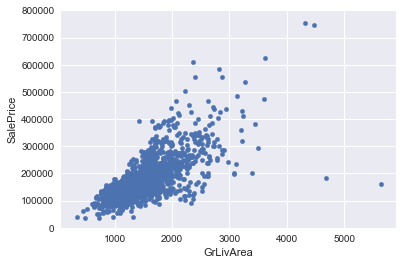

In [214]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [39]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

# Correlation

In [40]:
train['Total_sqr_footage'] = (train['BsmtFinSF1'] + train['BsmtFinSF2'] +
                                 train['1stFlrSF'] + train['2ndFlrSF'])

train['Total_Bathrooms'] = (train['FullBath'] + (0.5*train['HalfBath']) + 
                               train['BsmtFullBath'] + (0.5*train['BsmtHalfBath']))

train['Total_porch_sf'] = (train['OpenPorchSF'] + train['3SsnPorch'] +
                              train['EnclosedPorch'] + train['ScreenPorch'] +
                             train['WoodDeckSF'])

train = train.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath','HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF', 'LandSlope', 'Exterior2nd'])

In [41]:
test['Total_sqr_footage'] = (test['BsmtFinSF1'] + test['BsmtFinSF2'] +
                                 test['1stFlrSF'] + test['2ndFlrSF'])

test['Total_Bathrooms'] = (test['FullBath'] + (0.5*test['HalfBath']) + 
                               test['BsmtFullBath'] + (0.5*test['BsmtHalfBath']))

test['Total_porch_sf'] = (test['OpenPorchSF'] + test['3SsnPorch'] +
                              test['EnclosedPorch'] + test['ScreenPorch'] +
                             test['WoodDeckSF'])

test = test.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath','HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF', 'LandSlope', 'Exterior2nd'])

In [51]:
# MiscFeature,Fence,Utilities
train = train.drop(["Id", "Fence", "MiscFeature", "Utilities"], axis=1)
test = test.drop(["Id", "Fence", "MiscFeature", "Utilities"], axis=1)

In [219]:
print('training data+++++++++++++++++++++')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str(n) + ' nans')

print('testing data++++++++++++++++++++++ ')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(test.columns.values)[i] + ': ' + str(n) + ' nans')

training data+++++++++++++++++++++
testing data++++++++++++++++++++++ 


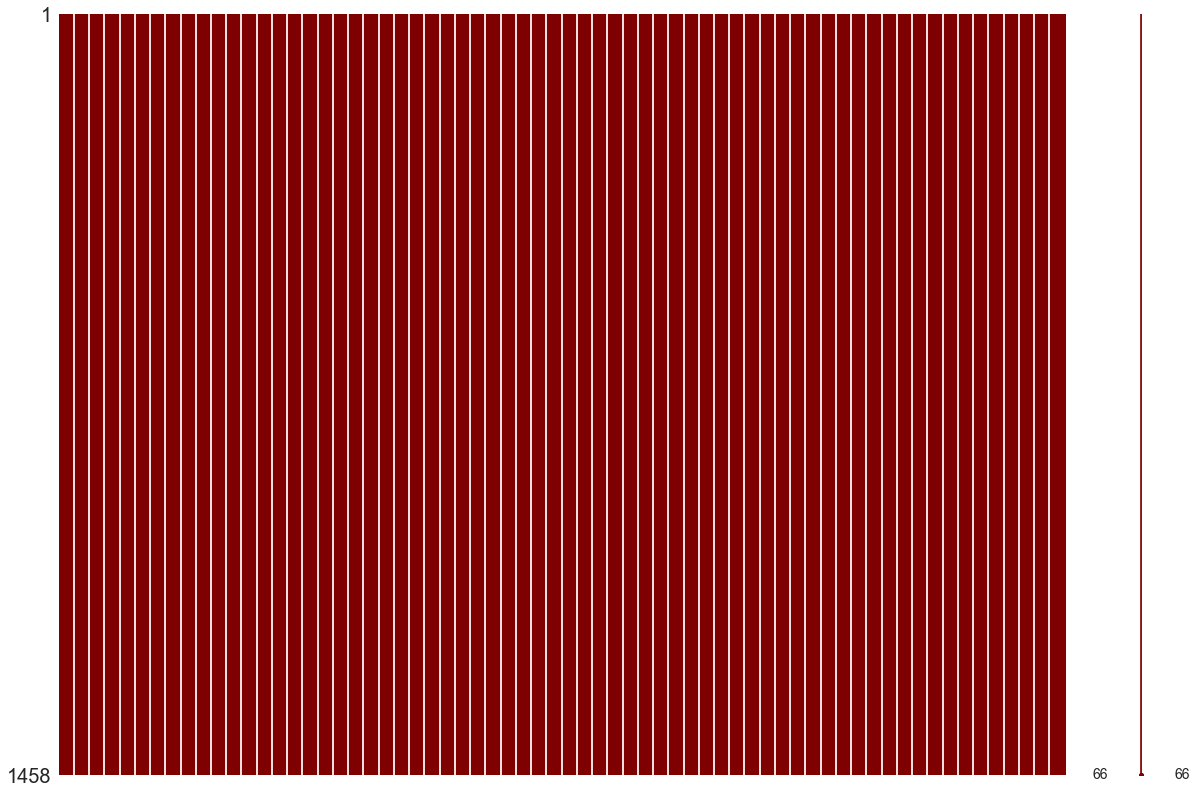

In [220]:
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

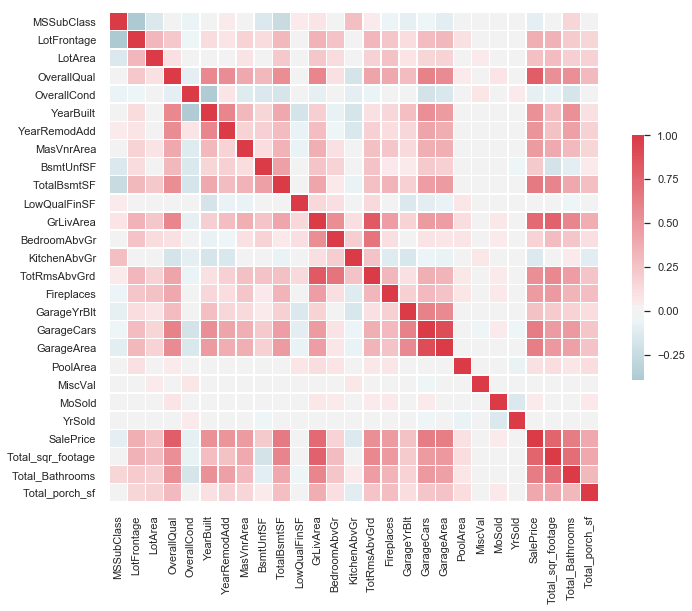

In [55]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap = cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

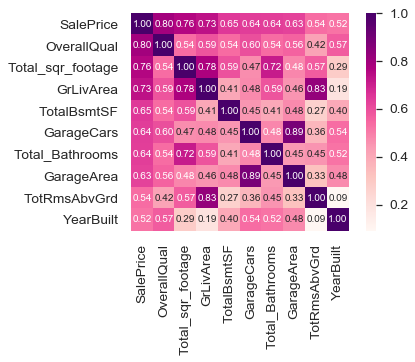

In [59]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap='RdPu' ,cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
#'RdPu'

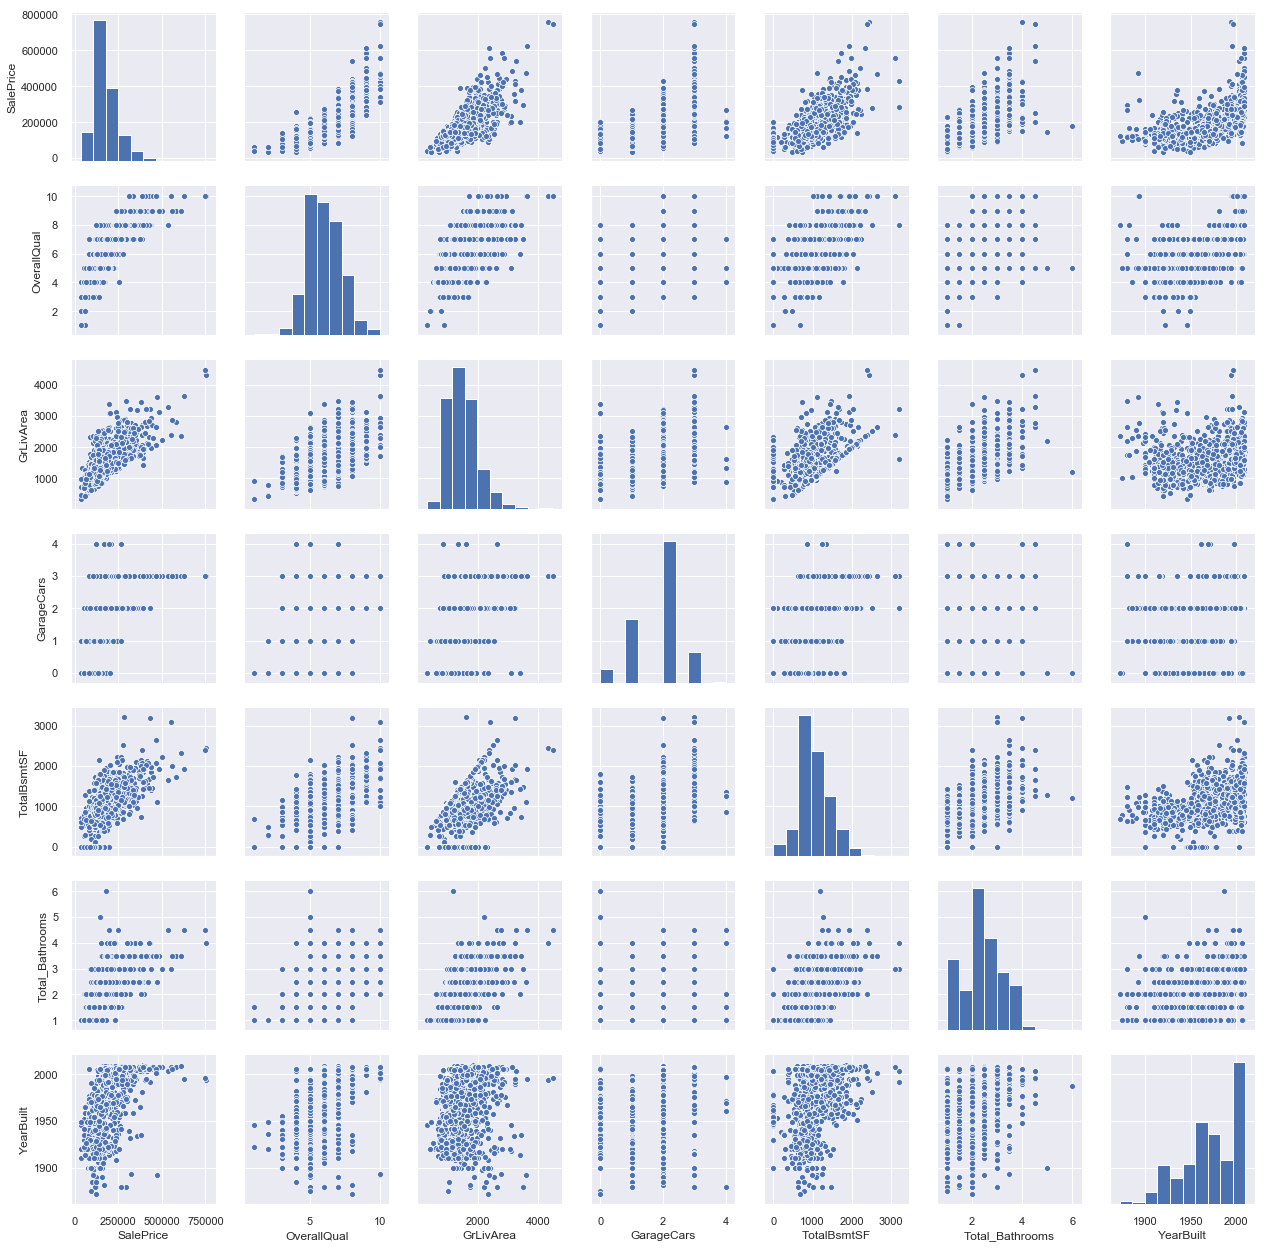

In [62]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'Total_Bathrooms', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [224]:
train.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
Id,1.000000,0.011121,-0.016458,-0.037689,-0.030213,0.012925,-0.013463,-0.022694,-0.053952,-0.007499,-0.025908,-0.044191,0.003138,0.037649,0.003078,0.025227,-0.023122,0.013320,0.016863,0.014316,0.048476,-0.006195,0.023511,0.000378,-0.021673,-0.005101,0.002841,-0.032190
MSSubClass,0.011121,1.000000,-0.391693,-0.142033,0.032522,-0.059275,0.027757,0.040503,0.023423,-0.140810,-0.253194,0.046486,0.076778,-0.023455,0.281752,0.040335,-0.046009,-0.081033,-0.040248,-0.099790,0.008090,-0.007675,-0.013581,-0.021386,-0.084276,-0.008412,0.151642,-0.035195
LotFrontage,-0.016458,-0.391693,1.000000,0.316954,0.219604,-0.042199,0.119340,0.078202,0.163317,0.120492,0.313102,0.032811,0.341367,0.256067,-0.007730,0.318666,0.240200,0.109849,0.287938,0.314887,0.094581,0.010422,0.023207,0.006190,0.365777,0.343245,0.204716,0.151594
LotArea,-0.037689,-0.142033,0.316954,1.000000,0.091392,-0.002723,0.007462,0.007500,0.083715,-0.003251,0.223914,0.005536,0.232927,0.120311,-0.016796,0.175425,0.261176,0.071784,0.152484,0.163680,0.036491,0.039072,0.005744,-0.013699,0.268179,0.293434,0.191719,0.174999
OverallQual,-0.030213,0.032522,0.219604,0.091392,1.000000,-0.090442,0.571368,0.549827,0.398785,0.308990,0.538595,-0.030129,0.589414,0.101601,-0.184077,0.420621,0.392472,0.289417,0.600741,0.557230,0.044758,-0.031238,0.072531,-0.026575,0.795774,0.535679,0.535828,0.299601
OverallCond,0.012925,-0.059275,-0.042199,-0.002723,-0.090442,1.000000,-0.375572,0.074615,-0.124261,-0.136723,-0.174931,0.025414,-0.077423,0.013099,-0.087170,-0.055782,-0.022406,-0.006300,-0.185275,-0.150503,0.002321,0.068728,-0.003735,0.043795,-0.077948,-0.072821,-0.173007,0.037155
YearBuilt,-0.013463,0.027757,0.119340,0.007462,0.571368,-0.375572,1.000000,0.592105,0.308722,0.148836,0.400266,-0.183770,0.194397,-0.070992,-0.174630,0.091220,0.144982,0.271812,0.537301,0.477998,-0.005171,-0.034273,0.012975,-0.013250,0.523608,0.287341,0.523072,0.093077
YearRemodAdd,-0.022694,0.040503,0.078202,0.007500,0.549827,0.074615,0.592105,1.000000,0.172590,0.180958,0.294941,-0.062289,0.286758,-0.040869,-0.149406,0.188418,0.109898,0.146022,0.419882,0.370000,-0.003426,-0.010160,0.022020,0.036145,0.507717,0.263975,0.442201,0.176496
MasVnrArea,-0.053952,0.023423,0.163317,0.083715,0.398785,-0.124261,0.308722,0.172590,1.000000,0.113825,0.339578,-0.068674,0.368356,0.102929,-0.037730,0.268116,0.239226,0.132413,0.360825,0.360786,-0.020350,-0.029346,-0.005006,-0.007215,0.477810,0.388258,0.303978,0.152412
BsmtUnfSF,-0.007499,-0.140810,0.120492,-0.003251,0.308990,-0.136723,0.148836,0.180958,0.113825,1.000000,0.438979,0.028211,0.247073,0.166624,0.030161,0.251537,0.052128,0.042632,0.213675,0.184580,-0.034936,-0.023813,0.033997,-0.040953,0.214460,-0.187633,-0.106085,0.047925


# Log SalePrice

In [225]:
train["SalePrice"].describe()
# No negative price

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

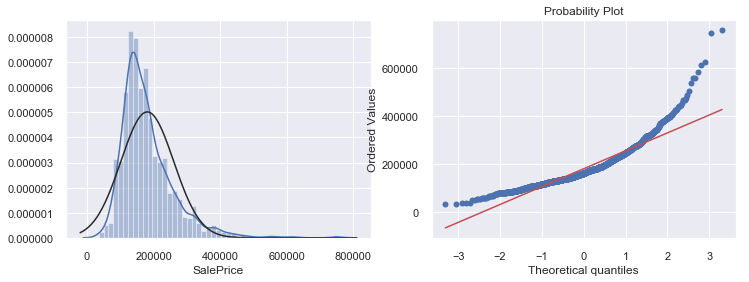

In [226]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(train.SalePrice, fit=norm);
plt.subplot(1,2,2)
_= stats.probplot(train.SalePrice, plot=plt)

In [227]:
y = train.SalePrice
log_y = np.log(y + 1)

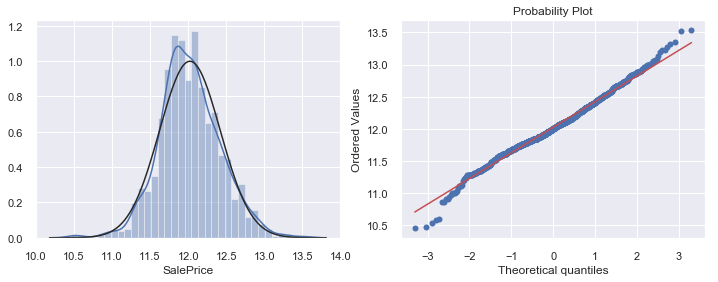

In [228]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(log_y, fit=norm);
plt.subplot(1,2,2)
_= stats.probplot(log_y, plot=plt)

### Correlations

In [229]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000000
OverallQual          0.795774
Total_sqr_footage    0.759782
GrLivArea            0.734968
TotalBsmtSF          0.651153
GarageCars           0.641047
Total_Bathrooms      0.635896
GarageArea           0.629217
TotRmsAbvGrd         0.537769
YearBuilt            0.523608
YearRemodAdd         0.507717
MasVnrArea           0.477810
Fireplaces           0.469862
Total_porch_sf       0.392897
LotFrontage          0.365777
LotArea              0.268179
GarageYrBlt          0.261435
BsmtUnfSF            0.214460
BedroomAbvGr         0.168245
PoolArea             0.099490
MoSold               0.046124
MiscVal             -0.021203
Id                  -0.021673
LowQualFinSF        -0.025625
YrSold              -0.028882
OverallCond         -0.077948
MSSubClass          -0.084276
KitchenAbvGr        -0.135946
Name: SalePrice, dtype: float64


### Dummify

In [230]:
train.shape

(1458, 66)

In [231]:
test.shape

(1459, 65)

In [232]:
col_to_dummie_train = train.dtypes[train.dtypes == object].index
train_dummified = train.drop(["SalePrice", "Id"], axis = 1)

for col in col_to_dummie_train:
    dummies = pd.get_dummies(train_dummified[col], prefix=col)
    max_freq = dummies.sum(axis = 0)
    for name in max_freq.index:
        if max_freq[name] == max_freq.max():
            drop_col = name
    train_dummified = pd.concat((dummies.drop(drop_col, axis = 1), train_dummified.drop(col, axis = 1)), axis=1)

In [233]:
col_to_dummie_test = test.dtypes[test.dtypes == object].index
test_dummified = test.drop(["Id"], axis = 1)

for col in col_to_dummie_test:
    dummies = pd.get_dummies(test_dummified[col], prefix=col)
    max_freq = dummies.sum(axis = 0)
    for name in max_freq.index:
        if max_freq[name] == max_freq.max():
            drop_col = name
    test_dummified = pd.concat((dummies.drop(drop_col,axis=1), test_dummified.drop(col, axis = 1)), axis=1)


In [234]:
train_dummified.shape

(1458, 222)

In [235]:
test_dummified.shape

(1459, 210)

In [236]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = test_dummified.select_dtypes(include = ["object"]).columns
numerical_features = test_dummified.select_dtypes(exclude = ["object"]).columns
#numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = test_dummified[numerical_features]
train_cat = test_dummified[categorical_features]

Numerical features : 210
Categorical features : 0


In [237]:
#log transformation for all skewed variables 
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

199 skewed numerical features to log transform


### Ridge

Tune mainpoint: Ridge is alpha (determines the flexibility of our models). higher regulation = less overfit/lose flexibility 

In [238]:
y = train.SalePrice
log_y = np.log(y + 1)
rr = Ridge(alpha=13)
rr.fit(train_dummified, log_y)
np.sqrt(-cross_val_score(rr, train_dummified, log_y, cv=5, scoring="neg_mean_squared_error")).mean()

0.8818763074741677

### Lasso 

In [239]:
lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummified, log_y)
np.sqrt(-cross_val_score(lsr, train_dummified, log_y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11286202307845786

### Feature Selection

In [240]:
coef = pd.Series(lsr.coef_, index = train_dummified.columns)

In [241]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 97 variables and eliminated the other 125 variables


In [242]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

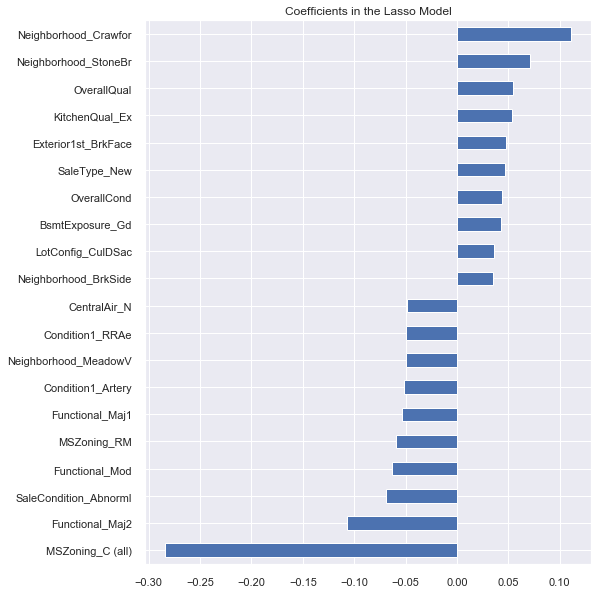

In [243]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# RUN Along


In [244]:
# data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# algorithm
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# training训练
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [245]:
rr = Ridge(alpha=13)
rr.fit(train_dummified, log_y)
np.sqrt(-cross_val_score(rr, train_dummified, log_y, cv=5, scoring="neg_mean_squared_error")).mean()

0.8367880975457475

In [246]:
y_pred = rr.predict(train_dummified)
resid = log_y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([   8,    9,   15,   28,   70,   75,  115,  118,  137,  161,  166,
        183,  185,  201,  250,  253,  268,  281,  309,  312,  320,  332,
        339,  347,  362,  367,  380,  425,  440,  454,  459,  461,  482,
        490,  496,  498,  503,  534,  597,  604,  620,  690,  709,  710,
        778,  782,  797,  829,  871,  872,  897,  913,  924,  934,  967,
        975, 1015, 1074, 1105, 1168, 1181, 1188, 1224, 1252, 1256, 1267,
       1286, 1313, 1317, 1324, 1344, 1348, 1368, 1371, 1379, 1399, 1402,
       1414, 1436, 1447])

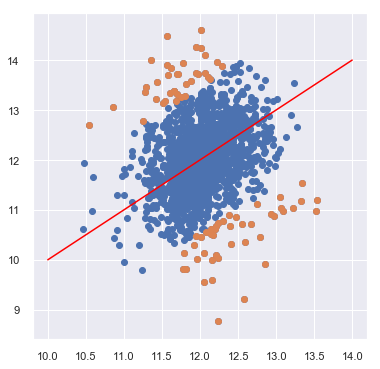

In [247]:
plt.figure(figsize=(6, 6))
plt.scatter(log_y, y_pred)
plt.scatter(log_y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

In [248]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummified, log_y)
np.sqrt(-cross_val_score(rr, train_dummified, log_y, cv=5, scoring="neg_mean_squared_error")).mean()

0.7742521443733119

In [249]:
y_pred = er.predict(train_dummified)
resid = log_y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   66,   70,   88,  142,  185,  218,  273,  277,  328,  410,
        431,  451,  457,  462,  479,  495,  528,  532,  559,  580,  587,
        627,  631,  657,  661,  665,  680,  687,  709,  710,  713,  727,
        737,  746,  773,  802,  811,  873,  884,  915,  967,  969, 1061,
       1067, 1121, 1180, 1210, 1322, 1335, 1430, 1451])

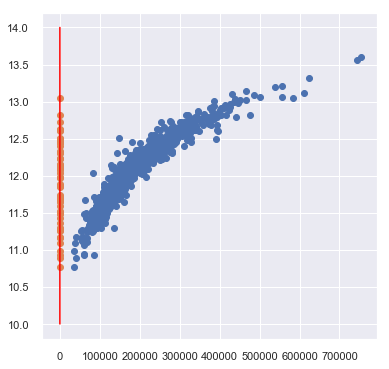

In [250]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(log_y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

In [251]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

[70, 185, 709, 710, 967]

In [110]:
train = train.drop([30,
 66,
 70,
 88,
 142,
 185,
 218,
 277,
 328,
 410,
 431,
 457,
 462,
 479,
 495,
 528,
 532,
 559,
 580,
 587,
 627,
 631,
 657,
 661,
 665,
 680,
 687,
 709,
 713,
 727,
 737,
 773,
 802,
 811,
 873,
 884,
 915,
 967,
 969,
 1061,
 1121,
 1180,
 1210,
 1322,
 1335,
 1430,
 1451])
#train = train.drop(columns = ['LandSlope','Exterior2nd']) omit since i did that earlier
y = train["SalePrice"]
y = np.log(y+1)

In [111]:
col_to_dummie_train = train.dtypes[train.dtypes == object].index
train_dummified = train.drop(["SalePrice", "Id"], axis = 1)

for col in col_to_dummie_train:
    dummies = pd.get_dummies(train_dummified[col], prefix=col)
    max_freq = dummies.sum(axis = 0)
    for name in max_freq.index:
        if max_freq[name] == max_freq.max():
            drop_col = name
    train_dummified = pd.concat((dummies.drop(drop_col, axis = 1), train_dummified.drop(col, axis = 1)), axis=1)

In [112]:
col_to_dummie_test = test.dtypes[test.dtypes == object].index
test_dummified = test.drop(["Id"], axis = 1)

for col in col_to_dummie_test:
    dummies = pd.get_dummies(test_dummified[col], prefix=col)
    max_freq = dummies.sum(axis = 0)
    for name in max_freq.index:
        if max_freq[name] == max_freq.max():
            drop_col = name
    test_dummified = pd.concat((dummies.drop(drop_col,axis=1), test_dummified.drop(col, axis = 1)), axis=1)


In [113]:
train_dummified.shape

(1411, 222)

In [114]:
test_dummified.shape

(1459, 210)

In [115]:
col_test = list(test_dummified.columns.values)
col_train = list(train_dummified.columns.values)

index = 0
i = 0
not_equal = []

for col in col_train:
    for col2 in col_test:
        if col == col2:
            index += 1
    if index == 0:
        not_equal.append(col)
    index = 0
        
not_equal

['GarageQual_Ex',
 'Electrical_Mix',
 'Heating_Floor',
 'Heating_OthW',
 'BsmtFinType1_GLQ',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'HouseStyle_2.5Fin',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn']

In [116]:
for col in not_equal:
    col_name = col.split("_")[0]
    drop_col = list(train_dummified.filter(like = col_name, axis = 1).columns.values)
    train_dummified = train_dummified.drop(drop_col, axis=1)
    drop_col_test = list(test_dummified.filter(like = col_name, axis = 1).columns.values)
    test_dummified = test_dummified.drop(drop_col_test, axis=1)

In [129]:
test_dummified = test_dummified.drop('MSZoning_Unf', axis=1)

In [130]:
test_dummified.shape

(1459, 164)

In [131]:
train_dummified.shape

(1411, 164)

In [127]:
train_col = list(train_dummified.columns.values)
test_col = list(test_dummified.columns.values)
list(set(train_col)^set(test_col))

['MSZoning_Unf']

In [119]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(train_dummified, y)
np.sqrt(-cross_val_score(gbr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11245085086215545

In [120]:
xgbr = XGBRegressor(max_depth=5, n_estimators=400)
xgbr.fit(train_dummified, y)
np.sqrt(-cross_val_score(xgbr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11081283539284406

In [121]:
lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummified, y)
np.sqrt(-cross_val_score(lsr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.10575790332177123

In [122]:
rr = Ridge(alpha=13)
rr.fit(train_dummified, y)
np.sqrt(-cross_val_score(rr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.10611891034846532

In [123]:
train_predict = 0.1 * gbr.predict(train_dummified) + 0.3 * xgbr.predict(train_dummified) + 0.3 * lsr.predict(train_dummified) + 0.3 * rr.predict(train_dummified)

In [124]:
train_predict

array([12.22818805, 12.16150541, 12.26086195, ..., 12.48234528,
       11.83959224, 11.94383993])

# Predicting

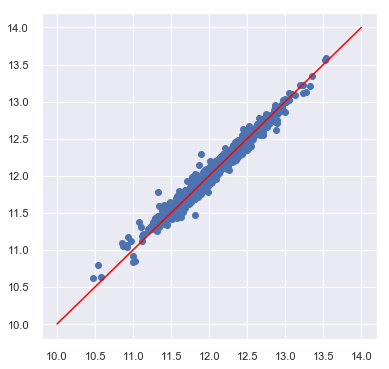

In [125]:
q1 = pd.DataFrame(train_predict).quantile(0.0042)
pre_df = pd.DataFrame(train_predict)
pre_df["SalePrice"] = train_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.99
train_predict = np.array(pre_df.SalePrice)
plt.figure(figsize=(6, 6))
plt.scatter(y, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")

In [134]:
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [135]:
test_predict = 0.1 * gbr.predict(test_dummified) + 0.3 * xgbr.predict(test_dummified) + 0.3 * lsr.predict(test_dummified) + 0.3 * rr.predict(test_dummified)
q1 = pd.DataFrame(test_predict).quantile(0.0042)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.96
test_predict = np.array(pre_df.SalePrice)
sample_submission["SalePrice"] = np.exp(test_predict)-1
sample_submission.to_csv("1.csv", index=False)